In [1]:
import csv
import numpy as np
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import pickle
import pandas as pd
#import tensorflow as tf
import json
from sklearn.model_selection import train_test_split
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir='../data/Current Data/'

In [3]:
CategoricalFeatures=[]
NumericFeatures=[]

demographics

In [4]:
df_demographics=pd.read_csv(data_dir+'REACT_Demographics'+'.csv')
#df_demographics.info()

In [5]:
#df_demographics.head()

In [6]:
#df_demographics.columns

In [7]:
CategoricalFeatures+=['GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']
NumericFeatures+=['PATIENT_AGE']

In [8]:
studyid_data_dic=dict()
for studyid,age,gender,ethnic,smoking in df_demographics[['STUDY_ID','PATIENT_AGE','GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']].values:
    if age is not np.nan and gender is not np.nan and ethnic is not np.nan and smoking is not np.nan:
        if studyid not in studyid_data_dic:
            studyid_data_dic[studyid]=dict()
        studyid_data_dic[studyid]['PATIENT_AGE']=age
        studyid_data_dic[studyid]['GENDER']=str(gender)
        studyid_data_dic[studyid]['ETHNIC_GROUP']=ethnic
        studyid_data_dic[studyid]['SMOKING_HISTORY']=smoking
#studyid_data_dic

Comorbidities

In [9]:
df_comorbidities=pd.read_csv(data_dir+'REACT_Comorbidities_unpivoted'+'.csv')
#df_demographics.info()

In [10]:
comorbidities=list(df_comorbidities.COMORBIDITY.unique())
NumericFeatures+=comorbidities
for studyid in studyid_data_dic:
    for co in comorbidities:
        studyid_data_dic[studyid][co]=0

In [11]:
for studyid,co,status in df_comorbidities.values:
    if studyid in studyid_data_dic:
        studyid_data_dic[studyid][co]=status
#studyid_data_dic

label: Death or not

In [12]:
df_label=df_demographics[df_demographics.DATE_OF_DEATH.notna()][['STUDY_ID','DATE_OF_DEATH']]

In [13]:
from datetime import datetime

label_studyid_time_dic=dict()
for study_id,start_datetime in df_label.values:
    start_datetime=datetime.strptime(start_datetime,'%Y-%m-%d %H:%M:%S')
    if study_id not in label_studyid_time_dic or label_studyid_time_dic[study_id]>start_datetime:
        label_studyid_time_dic[study_id]=start_datetime

#label_studyid_time_dic

In [14]:
for studyid in studyid_data_dic:
    if studyid not in label_studyid_time_dic:
        studyid_data_dic[studyid]['TIME_POINT']=None
        studyid_data_dic[studyid]['PREDICTION_LABEL']=0
    else:
        start_datetime=label_studyid_time_dic[studyid]
        studyid_data_dic[studyid]['TIME_POINT']=start_datetime
        studyid_data_dic[studyid]['PREDICTION_LABEL']=1

labresults

In [15]:
df_labresults=pd.read_csv(data_dir+'REACT_LabResults'+'.csv')
#df_labresults.info()

In [16]:
#df_labresults.head()

In [17]:
testcode_lst=list(df_labresults.REACT_TESTCODE.unique())
testcode2id=dict([(testcode_lst[i],i) for i in range(len(testcode_lst))])

In [18]:
from datetime import datetime

studyid_testcode_time_numeric_dic=dict()
for studyid,test_time,testcode,numeric,lower,upper in df_labresults[[
    'STUDY_ID','PATHOLOGY_SPECIMEN_DATE','REACT_TESTCODE',
    'PATHOLOGY_RESULT_NUMERIC','LOWER_RANGE','UPPER_RANGE']].values:
    test_time=datetime.strptime(test_time,'%Y-%m-%d %H:%M:%S')
    if studyid not in studyid_testcode_time_numeric_dic:
        studyid_testcode_time_numeric_dic[studyid]=[]
    studyid_testcode_time_numeric_dic[studyid].append([test_time,testcode,numeric])
#studyid_testcode_time_numeric_dic

In [19]:
NumericFeatures+=[testcode+suffix for testcode in testcode_lst for suffix in ['_MIN','_MAX','_MEAN']]

In [20]:
for studyid in studyid_data_dic:
    for testcode in testcode_lst:
        for suffix in ['_MIN','_MAX','_MEAN']:
            studyid_data_dic[studyid][testcode+suffix]=None
    time_point=studyid_data_dic[studyid]['TIME_POINT']
    if studyid in studyid_testcode_time_numeric_dic:
        individual_labresult_dic=dict()
        for test_time,testcode,numeric in studyid_testcode_time_numeric_dic[studyid]:
            if time_point is None or test_time<time_point:
                if testcode not in individual_labresult_dic:
                    individual_labresult_dic[testcode]=[]
                individual_labresult_dic[testcode].append(numeric)
        for testcode in individual_labresult_dic:
            studyid_data_dic[studyid][testcode+'_MIN']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MAX']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MEAN']=np.mean(individual_labresult_dic[testcode])

data preprocessing

In [21]:
studyid_lst=list(studyid_data_dic.keys())
#studyid_lst

In [22]:
X_cols=[]

In [23]:
from sklearn.preprocessing import OneHotEncoder

X_categorical=[[studyid_data_dic[studyid][k] for k in CategoricalFeatures] for studyid in studyid_lst]

enc = OneHotEncoder(handle_unknown='ignore')
X_onehot=enc.fit_transform(X_categorical).toarray()

X_cols+=list(enc.get_feature_names(CategoricalFeatures))

In [24]:
X_numeric=[[studyid_data_dic[studyid][k] for k in NumericFeatures] for studyid in studyid_lst]
X_cols+=NumericFeatures

In [25]:
X_missing_value=np.concatenate((X_onehot,X_numeric), axis=1)

In [26]:
Y=np.array([studyid_data_dic[studyid]['PREDICTION_LABEL'] for studyid in studyid_lst])

In [27]:
balance_ratio=len([_ for v in Y if v==0])/len([_ for v in Y if v==1])
balance_ratio

2.4

In [28]:
from functools import reduce

XY_missing_value_balanced=np.array(
    reduce(lambda a,b:a+b,[[list(x)+[y]]*(int(balance_ratio) if y==1 else 1) for x,y in zip(X_missing_value,Y)])
)

X_missing_value=XY_missing_value_balanced[:,:-1]
Y=np.array(XY_missing_value_balanced[:,-1],dtype=int)

fill in nan

In [29]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X=imputer.fit_transform(X_missing_value)

Prediction Classification task (RespiratorySupportRequired:1 or not:0)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models={
    "Logit":LogisticRegression(solver="lbfgs"),
    "MLP":MLPClassifier(max_iter=3000,solver='adam', alpha=1e-3,hidden_layer_sizes=(64)),
    "DecisionTree":DecisionTreeClassifier(),
    "RandomForest":RandomForestClassifier(n_estimators=100),
    "AdaBoost":AdaBoostClassifier(n_estimators=100),
    "GradientBoost":GradientBoostingClassifier(n_estimators=100),
    "XGBoost":XGBClassifier(n_estimators=100)
}

In [31]:
from sklearn.model_selection import KFold

from sklearn.metrics import average_precision_score

ap_result_lst=[]

kf = KFold(n_splits=10,shuffle=True)

n_class=2

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    Y_test = np.zeros([len(y_test),n_class])
    for i in range(len(y_test)):
        Y_test[i,y_test[i]]=1
    ap_result_lst.append(
        [average_precision_score(Y_test,models[model_name].fit(X_train,y_train).predict_proba(X_test))\
                for model_name in models])

print(pd.DataFrame(ap_result_lst,columns=[model_name for model_name in models]))

      Logit       MLP  DecisionTree  RandomForest  AdaBoost  GradientBoost  \
0  0.771119  0.777677      0.773669      0.980404  0.867301       0.900634   
1  0.751867  0.705623      0.782870      0.920559  0.842031       0.868401   
2  0.724288  0.728881      0.858241      0.961149  0.832233       0.868752   
3  0.859130  0.834889      0.912327      0.947816  0.938510       0.935853   
4  0.705731  0.710168      0.824692      0.959568  0.805779       0.858714   
5  0.871346  0.759606      0.823229      0.965680  0.821605       0.914306   
6  0.837298  0.753555      0.824085      0.975010  0.909671       0.949237   
7  0.899010  0.768488      0.859761      0.978439  0.898842       0.929824   
8  0.922885  0.789252      0.828012      0.992833  0.947094       0.978805   
9  0.778483  0.712339      0.842097      0.972838  0.874930       0.917708   

    XGBoost  
0  0.973071  
1  0.885876  
2  0.934057  
3  0.926787  
4  0.934439  
5  0.948906  
6  0.979353  
7  0.940878  
8  0.977143  
9

In [32]:
print(pd.DataFrame(np.mean(ap_result_lst,axis=0,keepdims=True),columns=[model_name for model_name in models]))

      Logit       MLP  DecisionTree  RandomForest  AdaBoost  GradientBoost  \
0  0.812116  0.754048      0.832898       0.96543    0.8738       0.912223   

    XGBoost  
0  0.944642  


In [33]:
class_names=['Alive','Death']

In [34]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver="lbfgs").fit(X, Y)

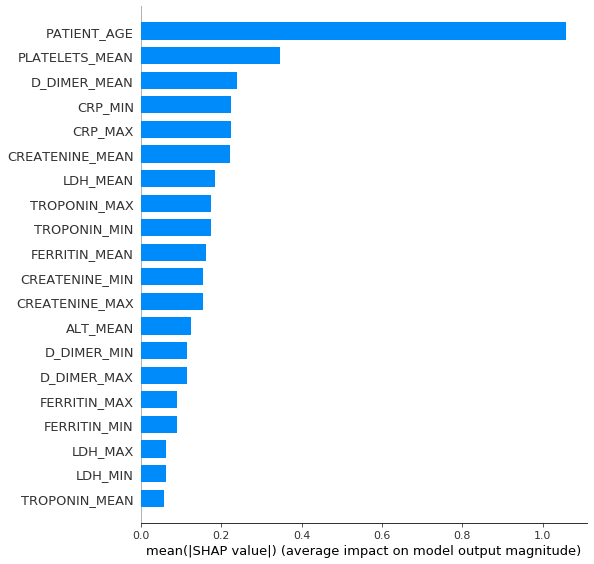

In [35]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.LinearExplainer(clf,X)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar",class_names=class_names)

In [36]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X, Y)

In [37]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

PATIENT_AGE : 0.1886583349408206
RENAL_D : 0.02592409449847526
UREA_MEAN : 0.025875493642781557
CARDIAC_D : 0.023795895505295213
MAGLINANT_NEO : 0.022729794514462987
CRP_MAX : 0.02161472658476098
CRP_MIN : 0.02127865558563706
TROPONIN_MAX : 0.01880128592801237
NEURAL_D : 0.01875238300281567
TROPONIN_MEAN : 0.017729002288619834
SMOKING_HISTORY_NR|NR : 0.01728381781560774
UREA_MAX : 0.01710397874116627
EOSINOPHILS_MEAN : 0.01566658637427853
HYPERTENSION : 0.015639040449176914
OBESITY : 0.013806930948844194
CRP_MEAN : 0.013442102241221117
PLATELETS_MEAN : 0.013388748406995584
DIABETES : 0.012604901055444127
SODIUM_MEAN : 0.012563619300196258
ETHNIC_GROUP_A : 0.012534125585928289


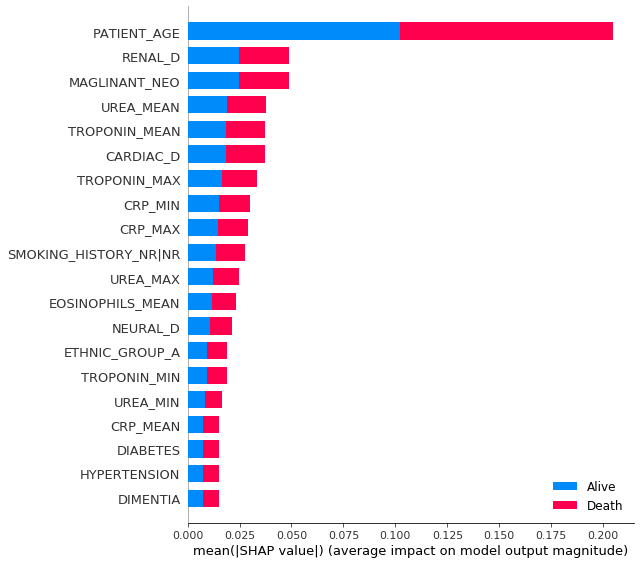

In [38]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar",class_names=class_names)

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100).fit(X, Y)

In [40]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

PATIENT_AGE : 0.32215253174051606
UREA_MEAN : 0.07342701427615428
CRP_MIN : 0.05875613179355966
PLATELETS_MEAN : 0.051648755861764976
CRP_MAX : 0.05124347647573188
TROPONIN_MEAN : 0.04915068551434207
MAGLINANT_NEO : 0.03466433564619644
EOSINOPHILS_MEAN : 0.029620001154798917
RENAL_D : 0.024514145016472408
LYMPHOCYTES_MEAN : 0.024368460928471218
NEUTROPHILS_MEAN : 0.017760461792080857
ALT_MEAN : 0.011641197623688062
SODIUM_MEAN : 0.011585086635643723
WBC_MIN : 0.01112559672784556
RHEUMATO_D : 0.010663329236992258
CRP_MEAN : 0.01025517727659063


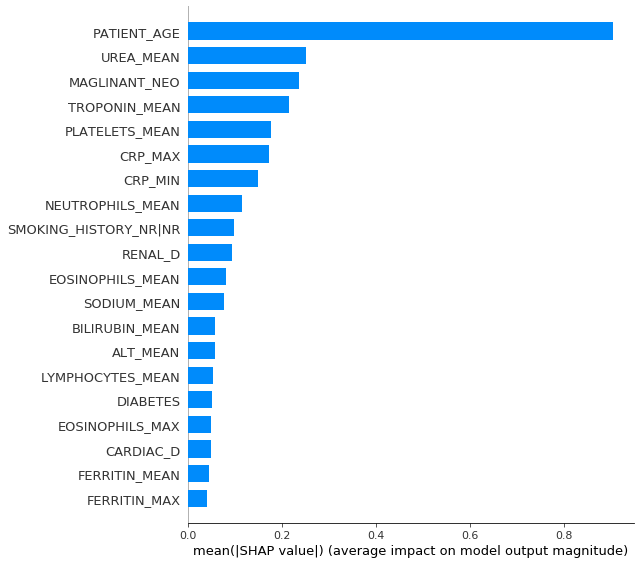

In [41]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar", class_names=class_names)

In [42]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=100).fit(X, Y)

In [43]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

LDH_MEAN : 0.06335539
CRP_MIN : 0.046788774
PLATELETS_MEAN : 0.04429713
FERRITIN_MIN : 0.04098743
UREA_MEAN : 0.036933683
TROPONIN_MEAN : 0.030249313
TROPONIN_MIN : 0.028549194
HB_MIN : 0.02742647
HB_MEAN : 0.025916638
PATIENT_AGE : 0.025631415
MAGLINANT_NEO : 0.021231811
NEUTROPHILS_MIN : 0.02006134
SODIUM_MIN : 0.01996988
GLUCOSE_MIN : 0.019110845
SODIUM_MEAN : 0.018449012
ASTHMA : 0.018228643
WBC_MIN : 0.01809563
LYMPHOCYTES_MIN : 0.017753838
RENAL_D : 0.017720561
EOSINOPHILS_MIN : 0.017365031
